In [1]:
import os

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter

def generate_density_map(img_shape, points, sigma=4):
    h, w = img_shape[:2]
    density = np.zeros((h, w), dtype=np.float32)

    for y, x in points:
        if y < h and x < w:
            density[int(y), int(x)] = 1

    density = gaussian_filter(density, sigma=sigma)

    return density


In [3]:
import cv2

def downsample_density(density, factor=8):
    h, w = density.shape
    density_ds = cv2.resize(
        density,
        (w // factor, h // factor),
        interpolation=cv2.INTER_CUBIC
    )

    density_ds *= factor * factor
    return density_ds


In [4]:
from torch.utils.data import Dataset
import torch
import cv2

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, transform=None):
        self.imgs = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.transform = transform

    def __getitem__(self, idx):
        img = cv2.imread(f"{self.img_dir}/{self.imgs[idx]}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        density = np.load(f"{self.den_dir}/{self.imgs[idx].replace('.jpg','.npy')}")

        if self.transform:
            img = self.transform(img)

        density = torch.from_numpy(density).unsqueeze(0)
        return img, density

    def __len__(self):
        return len(self.imgs)


### CSRNet Model

In [5]:
import torch
import torch.nn as nn

cfg = {
    'frontend': [64,64,'M',128,128,'M',256,256,256,'M',512,512,512],
    'backend' : [512,512,512,256,128,64]
}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers = []
    for v in cfg_list:
        if v == 'M':
            layers.append(nn.MaxPool2d(2,2))
        else:
            d = 2 if dilation else 1
            layers += [
                nn.Conv2d(in_channels, v, kernel_size=3, padding=d, dilation=d),
                nn.ReLU(inplace=True)
            ]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        self.frontend = make_layers(cfg['frontend'], in_channels=3, dilation=False)
        self.backend  = make_layers(cfg['backend'], in_channels=512, dilation=True)
        self.output   = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CSRNet()
model.load_state_dict(torch.load("/content/drive/MyDrive/crowd_project/CSRNet_best.pth", map_location=device))
model.to(device)
model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

### Loss Function and Optimizer & Learning Rate

In [7]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-6,
    weight_decay=1e-4
)


### Define image transforms

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


### Initialize Dataset

In [9]:
train_dataset = CrowdDataset(
    img_dir="/content/drive/MyDrive/crowd_project/finetuning_data/images",
    den_dir="/content/drive/MyDrive/crowd_project/finetuning_data/density",
    transform=transform
)


### DataLoader

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [11]:
import cv2
import numpy as np

img = cv2.imread("/content/drive/MyDrive/crowd_project/finetuning_data/images/frame_1.jpg")
density = np.load("/content/drive/MyDrive/crowd_project/finetuning_data/density/frame_1.npy")

print("Image shape   :", img.shape)      # (H, W, 3)
print("Density shape :", density.shape)   # (H/8, W/8)
print("Density sum   :", density.sum())

Image shape   : (432, 768, 3)
Density shape : (54, 96)
Density sum   : 22.959097


In [12]:
import torch

img_t = torch.randn(1, 3, img.shape[0], img.shape[1]).to(device)
pred = model(img_t)

print("Model output shape :", pred.shape)
print("GT expanded shape :", (1, 1, density.shape[0], density.shape[1]))

Model output shape : torch.Size([1, 1, 54, 96])
GT expanded shape : (1, 1, 54, 96)


### Freeze frontend

In [13]:
for p in model.frontend.parameters():
    p.requires_grad = False


### Training loop

In [14]:
epochs_phase1 = 8

for epoch in range(epochs_phase1):
    model.train()
    epoch_loss = 0.0

    for img, gt in train_loader:
        img = img.to(device)
        gt  = gt.to(device)

        pred = model(img)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[Phase-1] Epoch {epoch+1}/{epochs_phase1} | Loss: {epoch_loss:.2f}")


[Phase-1] Epoch 1/8 | Loss: 2434.63
[Phase-1] Epoch 2/8 | Loss: 2120.64
[Phase-1] Epoch 3/8 | Loss: 2021.71
[Phase-1] Epoch 4/8 | Loss: 1961.36
[Phase-1] Epoch 5/8 | Loss: 1884.51
[Phase-1] Epoch 6/8 | Loss: 1788.39
[Phase-1] Epoch 7/8 | Loss: 1723.13
[Phase-1] Epoch 8/8 | Loss: 1674.27


### Unfreeze frontend

In [15]:
for p in model.frontend.parameters():
    p.requires_grad = True


### Training loop

In [16]:
epochs_phase2 = 30

for epoch in range(epochs_phase2):
    model.train()
    epoch_loss = 0.0

    for img, gt in train_loader:
        img = img.to(device)
        gt  = gt.to(device)

        pred = model(img)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[Phase-2] Epoch {epoch+1}/{epochs_phase2} | Loss: {epoch_loss:.2f}")


[Phase-2] Epoch 1/30 | Loss: 1549.50
[Phase-2] Epoch 2/30 | Loss: 1439.99
[Phase-2] Epoch 3/30 | Loss: 1378.69
[Phase-2] Epoch 4/30 | Loss: 1334.12
[Phase-2] Epoch 5/30 | Loss: 1293.55
[Phase-2] Epoch 6/30 | Loss: 1258.13
[Phase-2] Epoch 7/30 | Loss: 1226.44
[Phase-2] Epoch 8/30 | Loss: 1196.85
[Phase-2] Epoch 9/30 | Loss: 1171.51
[Phase-2] Epoch 10/30 | Loss: 1154.00
[Phase-2] Epoch 11/30 | Loss: 1133.09
[Phase-2] Epoch 12/30 | Loss: 1117.33
[Phase-2] Epoch 13/30 | Loss: 1106.34
[Phase-2] Epoch 14/30 | Loss: 1094.33
[Phase-2] Epoch 15/30 | Loss: 1083.85
[Phase-2] Epoch 16/30 | Loss: 1076.10
[Phase-2] Epoch 17/30 | Loss: 1069.98
[Phase-2] Epoch 18/30 | Loss: 1061.44
[Phase-2] Epoch 19/30 | Loss: 1056.05
[Phase-2] Epoch 20/30 | Loss: 1050.43
[Phase-2] Epoch 21/30 | Loss: 1043.90
[Phase-2] Epoch 22/30 | Loss: 1039.29
[Phase-2] Epoch 23/30 | Loss: 1034.88
[Phase-2] Epoch 24/30 | Loss: 1031.89
[Phase-2] Epoch 25/30 | Loss: 1027.09
[Phase-2] Epoch 26/30 | Loss: 1025.26
[Phase-2] Epoch 27/30

In [17]:
model.eval()
img, gt = next(iter(train_loader))
img, gt = img.to(device), gt.to(device)

with torch.no_grad():
    pred = model(img)

print("GT count   :", gt.sum().item())
print("Pred count :", pred.sum().item())

GT count   : 16.91631317138672
Pred count : 19.370845794677734


### Visual Check

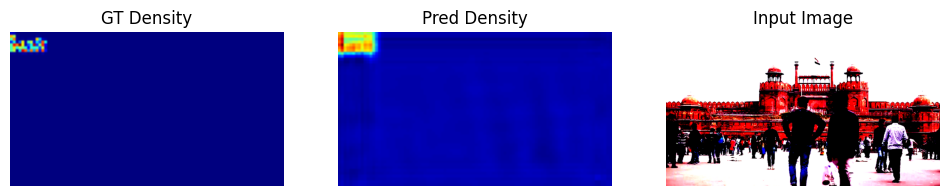

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(gt.squeeze().cpu(), cmap="jet")
plt.title("GT Density")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(pred.squeeze().cpu(), cmap="jet")
plt.title("Pred Density")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img[0].permute(1,2,0).cpu())
plt.title("Input Image")
plt.axis("off")

plt.show()

In [20]:
torch.save(model.state_dict(), "/content/drive/MyDrive/crowd_project/csrnet_finetuned.pth")